In [1]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import itertools
from glob import glob

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from tensorflow.keras.models import load_model
from annsa.model_classes import f1
from sklearn.metrics import f1_score, precision_score, recall_score
from annsa.load_pretrained_network import load_features

Using TensorFlow backend.


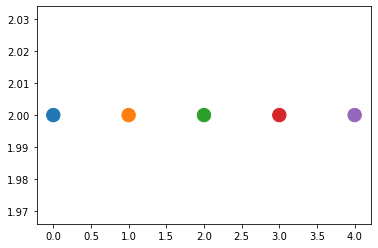

In [2]:
from aux_functions import *

# Load all models into dictionaries

In [3]:
all_models = {}

trainsize = '10000'

model_classes = ['dnn', 'cnn', 'daednn', 'caednn',]

for mode in ['easy', 'full']:
    for model_class in model_classes:
        print(model_class + ' ' + mode + '...')
        temp_models = []
        for i in range(5):
            i = str(i)
            identifier = '-final_trainsize'
            if model_classes == 'cnn':
                identifier = '-final-reluupdate_trainsize'

            temp_model = load_model(
                os.path.join('..',
                'final_training_notebooks',
                'final-models-keras',
                'learningcurve-'+model_class+'-'+mode+identifier+trainsize+'_fold'+i+'.hdf5',),
                custom_objects={'f1': f1},
                compile=False,
            )
            temp_models.append(temp_model)
        all_models[model_class+'-'+mode] = temp_models

scalers = {}
model_classes = ['dnn', 'cnn',]
for mode in ['easy', 'full']:
    for model_class in model_classes:
        architecture_id = '../final_training_notebooks/final-models/learningcurve-'+model_class+'-'+mode+'-final-features'
        model_features = load_features(architecture_id)
        scalers[model_class+'-'+mode] = model_features.scaler.transform
        if model_class == 'dnn':
            scalers['daednn'+'-'+mode] = model_features.scaler.transform
        if model_class == 'cnn':
            scalers['caednn'+'-'+mode] = model_features.scaler.transform


dnn easy...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
cnn easy...
daednn easy...
caednn easy...
dnn full...
cnn full...
daednn full...
caednn full...


In [17]:
temp = all_models['caednn-full'][0]
temp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 1024, 1)           0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 1024, 8)           136       
_________________________________________________________________
max_pooling1d_75 (MaxPooling (None, 512, 8)            0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 512, 16)           2064      
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 256, 16)           0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 256, 32)           8224      
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 128, 32)           0         
__________

## Plot F1 score vs integration time with different source-detector distances

In [4]:
spectra_dataframe_heights = pd.read_pickle('spectra_dataframe_heights_logspace')


In [55]:
def f1_score_bagged(model_ids,
                    all_models,
                    testing_spectra,
                    testing_keys_binarized,
                    metric_func,):
    '''
    Bags a specific model's f1_score from a dictionary of models.

    Inputs
        model_ids : string, list
            List of model_id strings to bag. Specific model_id examples are
            'dnn-full' or 'cae-easy'.
        all_models : dict
            Dictionary containing all models
        testing_spectra : numpy array
            Array containing multiple gamma-ray spectra
        testing_keys_binarized : numpy array
            Array containing one-hot encoded (binarized) keys corresponding to
            testing_spectra
        metric_func : function
            f1_score, precision_score, or recall_score function from sklearn

    Outputs
        f1_scores : dict, str, float
            Dictionary indexed by model_id in model_ids, contains f1 score for
            that model
    '''
    f1_scores = {}

    for model_id in model_ids:

        predictions = ensemble_predictions(all_models[model_id], scalers[model_id], testing_spectra)
        true_labels = testing_keys_binarized.argmax(axis=1)

        f1_scores[model_id] = metric_func(
            true_labels,
            predictions,
            average='macro')

    return f1_scores

def plot_f1_scores_bagged(dataframe,
                          model_ids,
                          all_models,
                          indep_variable,
                          plot_label,
                          linestyle,
                          color,
                          ax,
                          metric_func,
                          **kwargs,
                          ):
    '''
    Plots the F1 scores for model's in model_ids given some dataframe of spectra.

    Inputs
        dataframe : Pandas DataFrame
            DataFrame containing spectra, isotope names, and
            parameter options.
        model_ids : string, list
            List of model_id strings to bag. Specific model_id examples are
            'dnn-full' or 'cae-easy'.
        all_models : dict
            Dictionary containing all models
        indep_variable : str
            The key for accessing the data column that contains the independent
            variable data. This data is plotted on the x-axis.
        kwargs : list, int, float
            Choices of different parameters to simulate

    Outputs
        None
    '''
    mlb = LabelBinarizer()
    keys = list(set(dataframe['isotope']))
    mlb.fit(keys)

    plt.rcParams.update({'font.size': 20})
    f1_scores_models = {}
    for key, value in kwargs.items():
        dataframe = dataframe[dataframe[key] == value]
    for model_id in model_ids:
        tmp_f1_scores = []
        for var in sorted(set(dataframe[indep_variable])):

            subset = dataframe[indep_variable] == var
            tmp_f1_score = f1_score_bagged(
                [model_id],
                all_models,
                np.vstack(dataframe[subset]['spectrum'].to_numpy()),
                mlb.transform(dataframe['isotope'])[subset],
                metric_func=metric_func,)
            tmp_f1_scores.append(tmp_f1_score[model_id])

        if plot_label:
            ax.plot(tmp_f1_scores,

                     linestyle=linestyle,
                     linewidth=2.5,
                     color=color,)
        else:
            ax.plot(tmp_f1_scores,
                     linestyle=linestyle,
                     linewidth=2.5,
                     color=color,)
    plt.ylim([0, 1])
    plt.xticks(
        range(len(sorted(set(dataframe[indep_variable])))),
        [round(var, 2) for var in sorted(set(dataframe[indep_variable]))])

In [62]:
def make_blank_plot(metric_str):

    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16,9))

    for ax in axs:
        for subax in ax:
            subax.set_ylim([0,110])

    axs[0, 0].set_title('S:B = 0.1')
    axs[0, 1].set_title('S:B = 0.5')

    axs[1, 0].set_xlabel('Integration Time (s)')
    axs[1, 1].set_xlabel('Integration Time (s)')

    axs[0, 0].set_ylabel('Dataset: Simple \n ' + metric_str)
    axs[1, 0].set_ylabel('Dataset: Complete \n ' + metric_str)
    return fig, axs


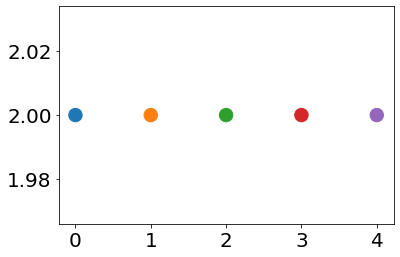

In [63]:
c1 = categorical_cmap(5,1, cmap="tab10")
plt.scatter(np.arange(5*1),np.ones(5*1)+1, c=np.arange(5*1), s=180, cmap=c1)

In [64]:
model_ids_all = {'easy' : ['caednn-easy', 'daednn-easy', 'dnn-easy', 'cnn-easy'],
             'full' : ['caednn-full', 'daednn-full', 'dnn-full', 'cnn-full'],
            }

linestyles = ['-', '--', '-.']

options = [50.0, 175.0, 300.0]

# F1 score

/home/ubuntu/anaconda3/envs/tensorflow_p36_update/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


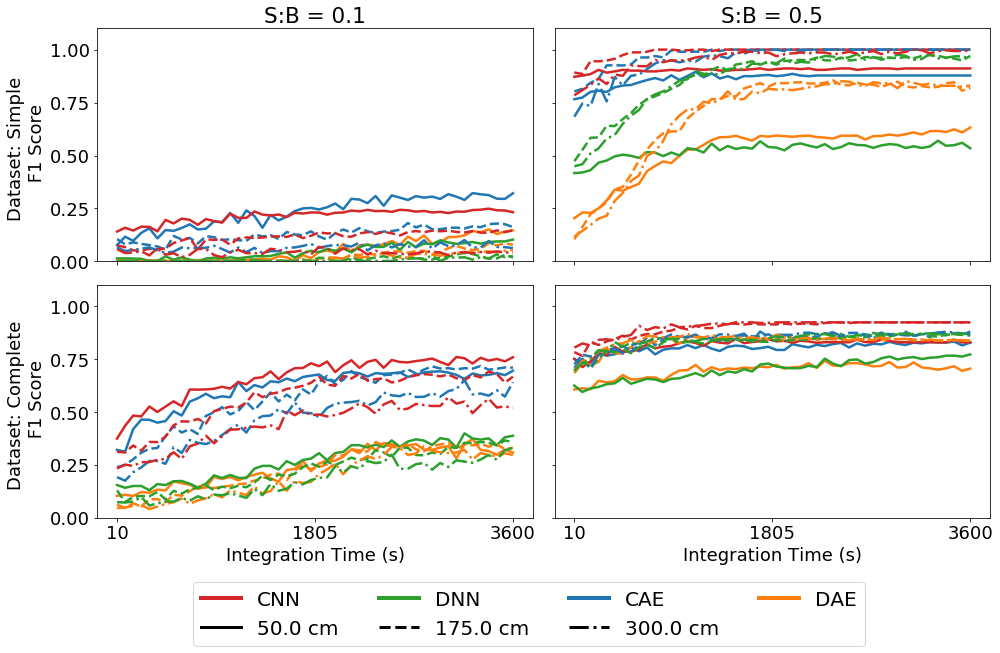

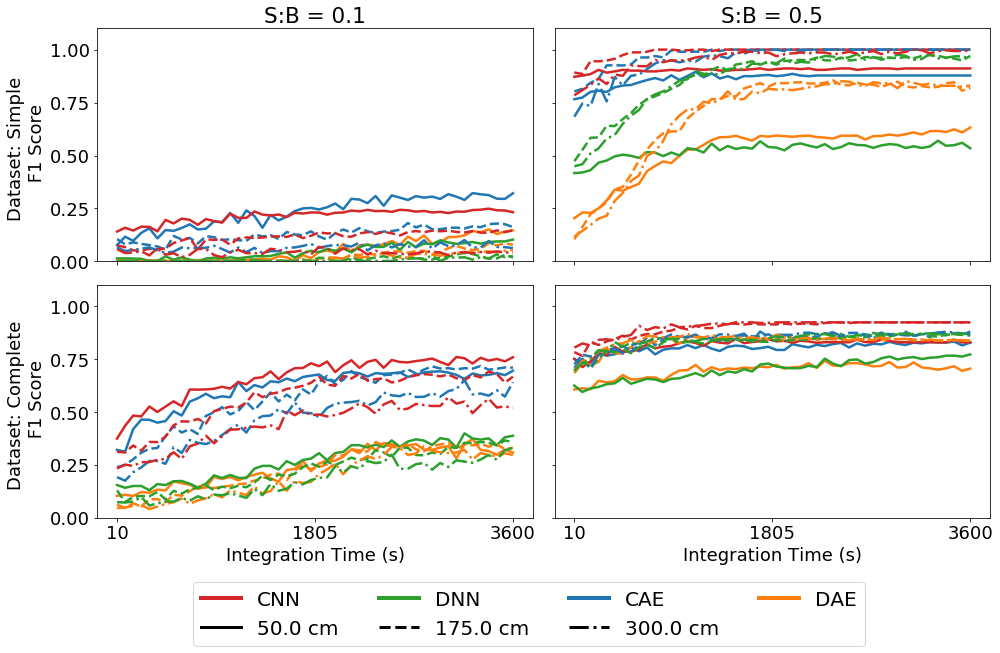

In [65]:
metric_str = 'F1 Score'
fig, axs = make_blank_plot(metric_str)
metric_func = f1_score

model_ids = model_ids_all['easy']
sb_ratio = '0.1'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[0][0]
                           )

model_ids = model_ids_all['easy']
sb_ratio = '0.5'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[0][1] 
                           )

model_ids = model_ids_all['full']
sb_ratio = '0.1'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[1][0] 
                           )

model_ids = model_ids_all['full']
sb_ratio = '0.5'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[1][1] 
                           )

_ = axs[1][1].set_xticks(np.linspace(0,len(set(spectra_dataframe_heights['integration_time']))-1,3))
_ = axs[1][1].set_xticklabels(np.linspace(10,3600,3).astype(int))
_ = axs[1][1].set_ylim([0,1.1])
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c1.colors[3], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[0], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[2], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[1], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[0], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[2], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[1], lw=4),
               ]
_ = axs[1][1].set_ylim([0,1.1])
axs[1][1].legend(custom_lines,
           ['CNN', str(options[0]) +' cm', 'DNN', str(options[1]) +' cm', 'CAE', str(options[2]) +' cm', 'DAE'], 
           loc=(-0.83,-0.55),
           ncol=4,
           prop={'size': 20},
           )

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig

# Precision

/home/ubuntu/anaconda3/envs/tensorflow_p36_update/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


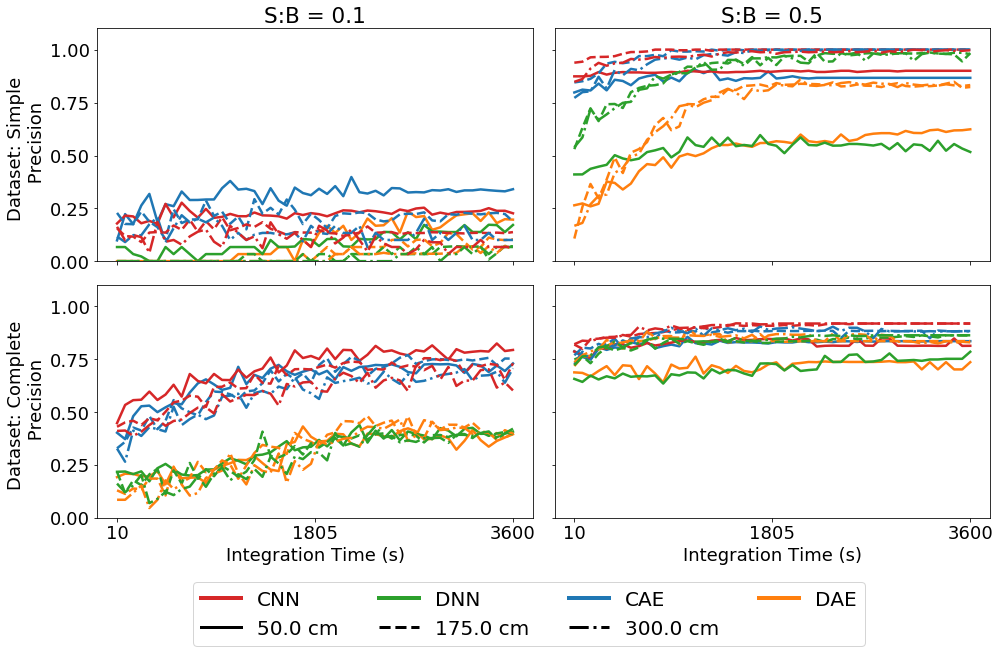

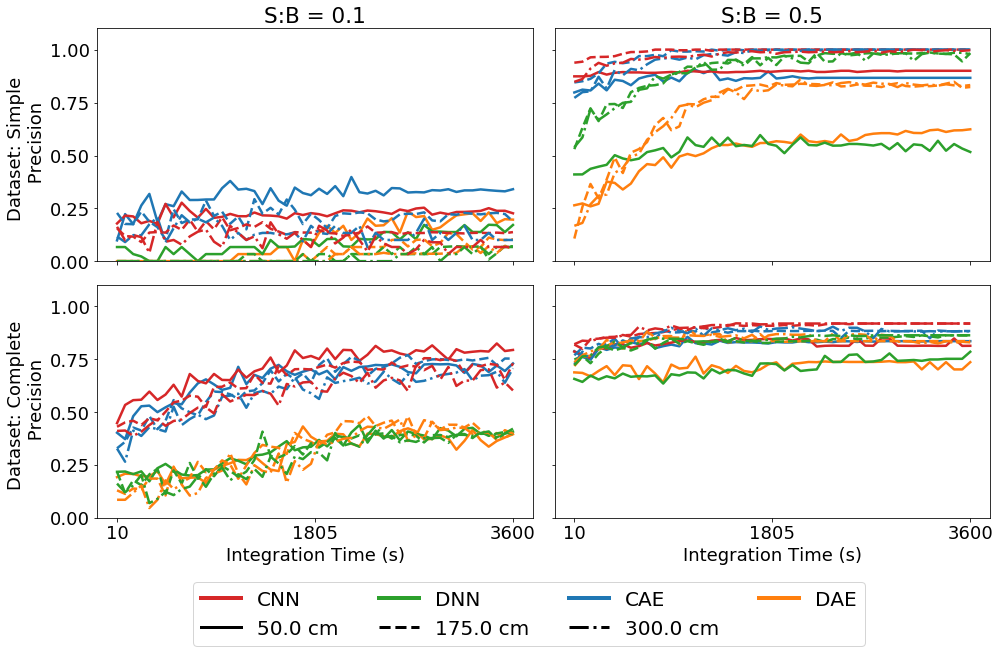

In [66]:
metric_str = 'Precision'
fig, axs = make_blank_plot(metric_str)
metric_func = precision_score

model_ids = model_ids_all['easy']
sb_ratio = '0.1'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[0][0]
                           )

model_ids = model_ids_all['easy']
sb_ratio = '0.5'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[0][1] 
                           )

model_ids = model_ids_all['full']
sb_ratio = '0.1'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[1][0] 
                           )

model_ids = model_ids_all['full']
sb_ratio = '0.5'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[1][1] 
                           )

_ = axs[1][1].set_xticks(np.linspace(0,len(set(spectra_dataframe_heights['integration_time']))-1,3))
_ = axs[1][1].set_xticklabels(np.linspace(10,3600,3).astype(int))
_ = axs[1][1].set_ylim([0,1.1])
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c1.colors[3], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[0], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[2], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[1], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[0], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[2], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[1], lw=4),
               ]
_ = axs[1][1].set_ylim([0,1.1])
axs[1][1].legend(custom_lines,
           ['CNN', str(options[0]) +' cm', 'DNN', str(options[1]) +' cm', 'CAE', str(options[2]) +' cm', 'DAE'], 
           loc=(-0.83,-0.55),
           ncol=4,
           prop={'size': 20},
           )

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig

# Recall

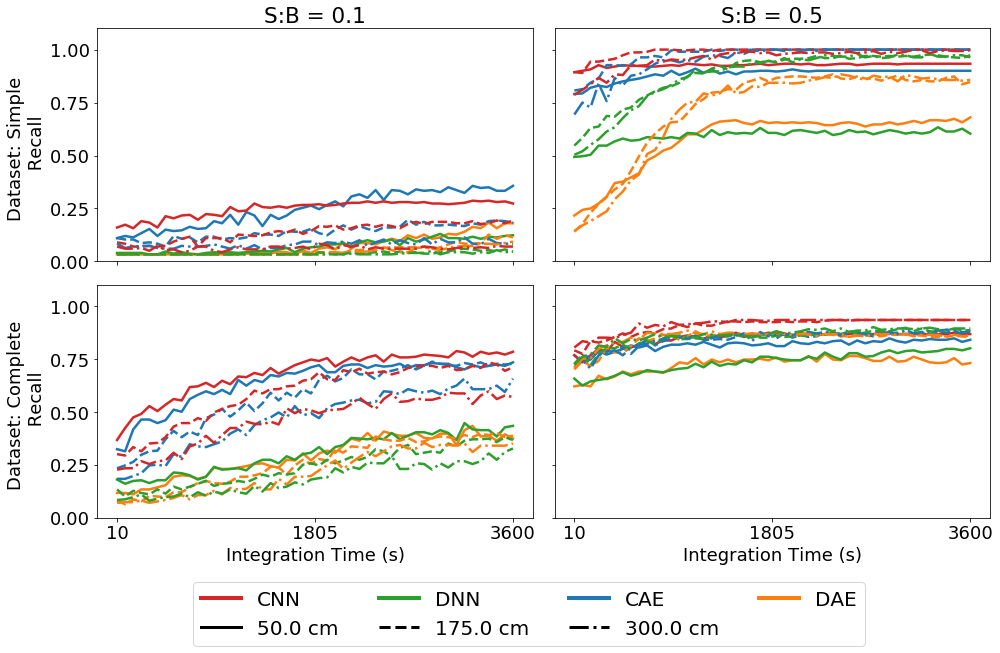

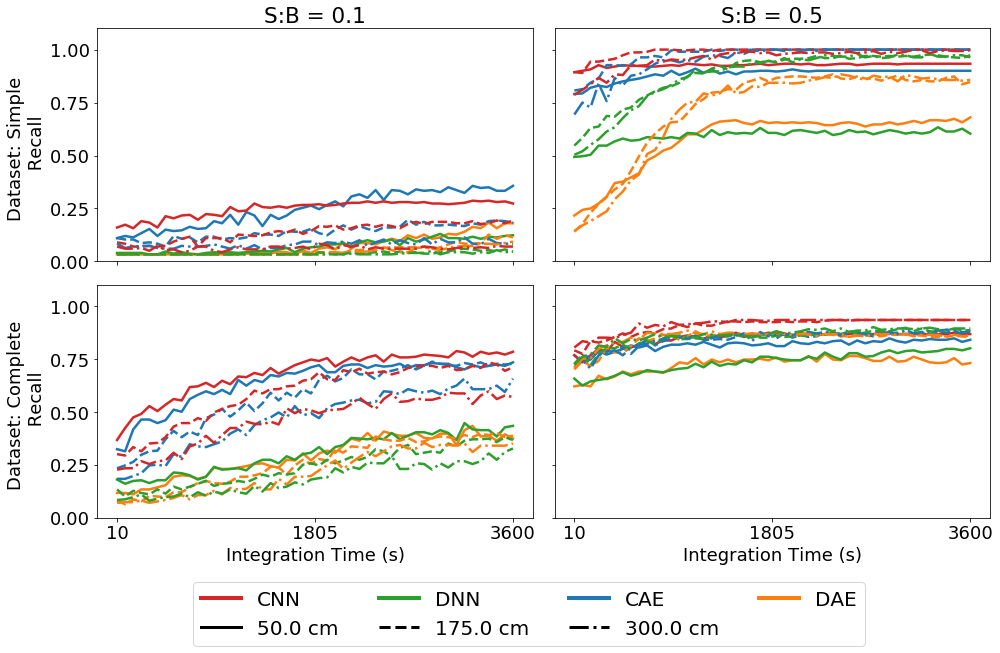

In [67]:
metric_str = 'Recall'
fig, axs = make_blank_plot(metric_str)
metric_func = recall_score

model_ids = model_ids_all['easy']
sb_ratio = '0.1'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[0][0]
                           )

model_ids = model_ids_all['easy']
sb_ratio = '0.5'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[0][1] 
                           )

model_ids = model_ids_all['full']
sb_ratio = '0.1'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.1,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[1][0] 
                           )

model_ids = model_ids_all['full']
sb_ratio = '0.5'
for option_index, option in enumerate(options):
    for model_id_index, model_id in enumerate(model_ids):
        plot_f1_scores_bagged(spectra_dataframe_heights,
                           model_ids=[model_id],
                           all_models=all_models,
                           metric_func=metric_func,
                           plot_label= str(option)+' '+str(model_id),
                           indep_variable = 'integration_time',
                           signal_to_background=0.5,
                           sourceheight=100.0,
                           sourcedist=option,
                           fwhm=7.0,
                           linestyle=linestyles[option_index],
                           color=c1.colors[model_id_index],
                           ax=axs[1][1] 
                           )

_ = axs[1][1].set_xticks(np.linspace(0,len(set(spectra_dataframe_heights['integration_time']))-1,3))
_ = axs[1][1].set_xticklabels(np.linspace(10,3600,3).astype(int))
_ = axs[1][1].set_ylim([0,1.1])
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c1.colors[3], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[0], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[2], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[1], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[0], lw=4),
                Line2D([0], [0], color='k', linestyle=linestyles[2], markersize=15, lw=3),
                Line2D([0], [0], color=c1.colors[1], lw=4),
               ]
_ = axs[1][1].set_ylim([0,1.1])
axs[1][1].legend(custom_lines,
           ['CNN', str(options[0]) +' cm', 'DNN', str(options[1]) +' cm', 'CAE', str(options[2]) +' cm', 'DAE'], 
           loc=(-0.83,-0.55),
           ncol=4,
           prop={'size': 20},
           )

fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig